In [79]:
import pandas as pd
import duckdb

In [81]:
con = duckdb.connect("/content/drive/MyDrive/MFM project/bankruptcy_data.db")

In [82]:
con.execute("SHOW TABLES").df().tail(10)

,name
401,ZTNO
402,ZVOI
403,bankrupted
404,bankrupted_prob_results
405,financial2
406,financial3
407,financial4
408,financials
409,non_bankrupted
410,non_bankrupted_prob_results


In [83]:
bankrupted = con.execute("SELECT * FROM bankrupted ").fetchdf().drop(columns = ['Date', 'Available']) # drop extra column to concat
bankrupted.columns = ['ticker', 'company', 'enddate', 'start_date']
non_bankrupted = con.execute("SELECT * FROM non_bankrupted ").fetchdf().drop(columns=['ticker']) # drop extra column to concat
non_bankrupted.columns = ['ticker', 'company', 'enddate', 'start_date']
bankrupted_probs = con.execute("SELECT * FROM bankrupted_prob_results ").fetchdf()
non_bankrupted_probs = con.execute("SELECT * FROM non_bankrupted_prob_results ").fetchdf()

In [84]:
bankrupted['bankrupted'] = 1
non_bankrupted['bankrupted'] = 0

In [85]:
bankrupted_data = pd.concat([bankrupted, non_bankrupted])
bankrupted_data.head()

,ticker,company,enddate,start_date,bankrupted
0,VELTF,Velti PLC,2015-12-24,2011-12-24,1
1,NOEC,New Oriental Energy & Chemical Corp,2015-12-24,2011-12-24,1
2,CRMBQ,Crumbs Bake Shop Inc,2015-12-24,2011-12-24,1
3,INOW,Infonow Corp,2015-12-18,2011-12-18,1
4,VALV,Shengkai Innovations Inc,2015-12-11,2011-12-11,1


In [86]:
bankrupted_probs.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default
0,RNVA,2015-12-31,0.000000e+00,0.94368
1,RNVA,2015-12-31,1.000000e+00,0.94282
2,RNVA,2015-12-31,0.000000e+00,0.94212
3,RNVA,2016-03-31,1.000000e+00,0.95122
4,RNVA,2016-06-30,8.346134e-42,0.42170


In [87]:
bankrupted_probs.ticker.nunique()

51

In [88]:
non_bankrupted_probs.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default
0,CRSP,2018-03-31,0.000000e+00,0.03058
1,CRSP,2018-06-30,2.298315e-04,0.03116
2,CRSP,2018-09-30,7.474074e-08,0.73244
3,CRSP,2018-12-31,2.990852e-07,0.62270
4,CRSP,2018-12-31,4.335628e-05,0.62516


In [89]:
non_bankrupted_probs.ticker.nunique()

69

In [90]:
prob_data = pd.concat([bankrupted_probs, non_bankrupted_probs])
prob_data.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default
0,RNVA,2015-12-31,0.000000e+00,0.94368
1,RNVA,2015-12-31,1.000000e+00,0.94282
2,RNVA,2015-12-31,0.000000e+00,0.94212
3,RNVA,2016-03-31,1.000000e+00,0.95122
4,RNVA,2016-06-30,8.346134e-42,0.42170


In [91]:
prob_and_bankrupt = prob_data.merge(bankrupted_data[['ticker', 'enddate', 'bankrupted']], on = 'ticker', how = 'left')
prob_and_bankrupt.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default,enddate,bankrupted
0,RNVA,2015-12-31,0.000000e+00,0.94368,2018-09-14,1
1,RNVA,2015-12-31,1.000000e+00,0.94282,2018-09-14,1
2,RNVA,2015-12-31,0.000000e+00,0.94212,2018-09-14,1
3,RNVA,2016-03-31,1.000000e+00,0.95122,2018-09-14,1
4,RNVA,2016-06-30,8.346134e-42,0.42170,2018-09-14,1


In [92]:
prob_and_bankrupt['year_end_1yb4'] = pd.to_datetime(prob_and_bankrupt['enddate']) + pd.offsets.DateOffset(years = -1) + pd.offsets.YearEnd(n = 0)
prob_and_bankrupt.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default,enddate,bankrupted,year_end_1yb4
0,RNVA,2015-12-31,0.000000e+00,0.94368,2018-09-14,1,2017-12-31
1,RNVA,2015-12-31,1.000000e+00,0.94282,2018-09-14,1,2017-12-31
2,RNVA,2015-12-31,0.000000e+00,0.94212,2018-09-14,1,2017-12-31
3,RNVA,2016-03-31,1.000000e+00,0.95122,2018-09-14,1,2017-12-31
4,RNVA,2016-06-30,8.346134e-42,0.42170,2018-09-14,1,2017-12-31


In [93]:
## clean up month in quarterend
prob_and_bankrupt['months'] = pd.to_datetime(prob_and_bankrupt['quarter_end']).dt.month
prob_and_bankrupt.months.value_counts()

,count
months,
12,1017
9,860
6,803
3,771


In [94]:
prob_and_bankrupt.shape

(3451, 8)

In [95]:
prob_and_bankrupt = prob_and_bankrupt[
    ((prob_and_bankrupt.quarter_end <= prob_and_bankrupt.year_end_1yb4) & prob_and_bankrupt.bankrupted == 1) |
    (prob_and_bankrupt.bankrupted == 0)
]

In [96]:
prob_and_bankrupt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3451 entries, 0 to 3450
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ticker            3451 non-null   object        
 1   quarter_end       3451 non-null   datetime64[us]
 2   kmv_prob_default  3397 non-null   float32       
 3   zpp_prob_default  3451 non-null   float32       
 4   enddate           3451 non-null   datetime64[us]
 5   bankrupted        3451 non-null   int64         
 6   year_end_1yb4     3451 non-null   datetime64[us]
 7   months            3451 non-null   int32         
dtypes: datetime64[us](3), float32(2), int32(1), int64(1), object(1)
memory usage: 175.4+ KB


In [97]:
prob_and_bankrupt.drop_duplicates(['ticker', 'quarter_end'], keep='last', inplace = True)

In [98]:
prob_and_bankrupt.shape

(1980, 8)

In [99]:
prob_and_bankrupt.head()

,ticker,quarter_end,kmv_prob_default,zpp_prob_default,enddate,bankrupted,year_end_1yb4,months
2,RNVA,2015-12-31,0.000000e+00,0.94212,2018-09-14,1,2017-12-31,12
3,RNVA,2016-03-31,1.000000e+00,0.95122,2018-09-14,1,2017-12-31,3
4,RNVA,2016-06-30,8.346134e-42,0.42170,2018-09-14,1,2017-12-31,6
5,RNVA,2016-09-30,0.000000e+00,0.97970,2018-09-14,1,2017-12-31,9
7,RNVA,2016-12-31,0.000000e+00,0.88128,2018-09-14,1,2017-12-31,12


In [100]:
arranged_prob_and_bankrupted_kmv = pd.DataFrame()
arranged_prob_and_bankrupted_zpp = pd.DataFrame()
for ticker in prob_and_bankrupt.ticker.unique():
    quarter_index = []
    temp = prob_and_bankrupt[prob_and_bankrupt.ticker == ticker].sort_values(by = 'quarter_end', ascending = False)
    for i, quarter in enumerate(temp.quarter_end):
        quarter_index.append(i+1)
    temp['quarter_index'] = quarter_index
    kmv_pivot = temp.pivot(index = 'ticker', columns = 'quarter_index', values = 'kmv_prob_default').round(4)
    zpp_pivot = temp.pivot(index = 'ticker', columns = 'quarter_index', values = 'zpp_prob_default').round(4)
    arranged_prob_and_bankrupted_kmv = pd.concat([arranged_prob_and_bankrupted_kmv, kmv_pivot])
    arranged_prob_and_bankrupted_zpp = pd.concat([arranged_prob_and_bankrupted_zpp, zpp_pivot])

In [101]:
arranged_prob_and_bankrupted_kmv = arranged_prob_and_bankrupted_kmv.sort_index(axis = 1, ascending = False)

In [102]:
arranged_prob_and_bankrupted_kmv.columns = ["B4Q" + str(x) for x in arranged_prob_and_bankrupted_kmv.columns.tolist()]
arranged_prob_and_bankrupted_kmv.head()

,B4Q26,B4Q25,B4Q24,B4Q23,B4Q22,B4Q21,B4Q20,B4Q19,B4Q18,B4Q17,...,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1
ticker,,,,,,,,,,,,,,,,,,,,,
RNVA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
GXXM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0095,0.0000,0.0040,0.6133,0.0024,0.9118
YUMAQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0004,0.0051,0.6908,0.0002,0.0088,0.8976,0.6143,0.6193,0.5713,0.8809
GLAE,NaN,NaN,NaN,NaN,NaN,0.0,0.0000,0.000,0.0,0.0,...,0.0231,0.5259,0.0000,0.2958,0.7304,0.0383,0.0261,0.6942,0.9650,0.6938
BMTM,NaN,NaN,NaN,NaN,NaN,NaN,0.0002,0.005,0.0,0.0,...,0.6692,0.7409,0.9936,0.0564,0.9189,0.6694,0.1970,0.3993,0.0488,0.8282


In [103]:
kmv_data = arranged_prob_and_bankrupted_kmv.dropna(axis = 1, thresh = 100).fillna(0).reset_index()

In [104]:
kmv_data

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1
0,RNVA,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,GXXM,0.0000,0.0000,0.0000,0.0000,0.0000,0.0095,0.0000,0.0040,0.6133,0.0024,0.9118
2,YUMAQ,0.1624,0.0004,0.0051,0.6908,0.0002,0.0088,0.8976,0.6143,0.6193,0.5713,0.8809
3,GLAE,0.0000,0.0231,0.5259,0.0000,0.2958,0.7304,0.0383,0.0261,0.6942,0.9650,0.6938
4,BMTM,0.3601,0.6692,0.7409,0.9936,0.0564,0.9189,0.6694,0.1970,0.3993,0.0488,0.8282
...,...,...,...,...,...,...,...,...,...,...,...,...
115,DXCM,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
116,DXC,0.6920,0.5015,0.1094,0.0522,0.0000,0.0000,0.0049,0.0000,0.0162,0.0282,0.0626
117,DGX,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
118,DG,0.5588,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0032


In [105]:
arranged_prob_and_bankrupted_zpp =  arranged_prob_and_bankrupted_zpp.sort_index(axis = 1, ascending = False)
arranged_prob_and_bankrupted_zpp.columns = ["B4Q" + str(x) for x in arranged_prob_and_bankrupted_zpp.columns.tolist()]
arranged_prob_and_bankrupted_zpp.reset_index(inplace = True)
zpp_data = arranged_prob_and_bankrupted_zpp[kmv_data.columns].fillna(0)

In [106]:
zpp_data

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1
0,RNVA,0.0000,0.0000,0.9421,0.9512,0.4217,0.9797,0.8813,0.8844,1.0000,0.9966,0.9761
1,GXXM,0.0000,0.0000,0.0000,0.0000,0.0000,0.7844,0.5833,0.6104,0.9581,0.7040,0.9752
2,YUMAQ,0.9436,1.0000,0.9993,0.0001,0.0000,0.9997,0.3683,1.0000,0.0000,0.8030,0.7131
3,GLAE,0.2493,0.7944,0.9976,0.6313,0.9622,0.8770,0.4174,0.8681,0.8235,0.1848,0.1354
4,BMTM,0.5205,0.1826,0.0045,0.8310,0.2792,0.0001,0.5574,0.9927,0.8548,0.5640,0.1970
...,...,...,...,...,...,...,...,...,...,...,...,...
115,DXCM,0.0233,0.0073,0.0354,0.0884,0.0091,0.9845,0.0212,0.0004,0.0002,0.6479,0.0002
116,DXC,0.0319,0.0802,0.0000,0.0105,0.0268,0.0050,0.0034,0.3007,0.3064,0.3434,0.0330
117,DGX,0.0005,0.0004,0.0054,0.0001,0.0000,0.0019,0.0000,0.0000,0.0000,0.0000,0.0707
118,DG,0.0003,0.0004,0.0000,0.0044,0.1070,0.0002,0.0000,0.0032,0.4924,0.9076,0.0187


In [107]:
kmv_data = kmv_data.merge(bankrupted_data[['ticker', 'bankrupted']], on = 'ticker', how = 'left')
zpp_data = zpp_data.merge(bankrupted_data[['ticker', 'bankrupted']], on = 'ticker', how = 'left')

In [108]:
kmv_data.tail()

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1,bankrupted
140,DXC,0.6920,0.5015,0.1094,0.0522,0.0,0.0000,0.0049,0.0,0.0162,0.0282,0.0626,0
141,DGX,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0
142,DG,0.5588,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0032,0
143,CVGW,0.4280,0.0000,0.0000,0.0000,0.0,0.0687,0.0000,0.0,0.0000,0.0000,0.0001,0
144,CVGW,0.4280,0.0000,0.0000,0.0000,0.0,0.0687,0.0000,0.0,0.0000,0.0000,0.0001,0


In [109]:
zpp_data.ticker.duplicated().sum(), kmv_data.ticker.duplicated().sum()

(np.int64(25), np.int64(25))

In [110]:
kmv_data = kmv_data.drop_duplicates(subset = 'ticker', keep = 'last')
zpp_data = zpp_data.drop_duplicates(subset = 'ticker', keep = 'last')

In [111]:
kmv_data.bankrupted.value_counts()

,count
bankrupted,
0,69
1,51


In [112]:
zpp_data.bankrupted.value_counts()

,count
bankrupted,
0,69
1,51


In [116]:
kmv_data.tail()

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1,bankrupted
139,DXCM,0.0001,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0
140,DXC,0.6920,0.5015,0.1094,0.0522,0.0,0.0000,0.0049,0.0,0.0162,0.0282,0.0626,0
141,DGX,0.0000,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0000,0
142,DG,0.5588,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0000,0.0000,0.0032,0
144,CVGW,0.4280,0.0000,0.0000,0.0000,0.0,0.0687,0.0000,0.0,0.0000,0.0000,0.0001,0


In [117]:
zpp_data.tail()

,ticker,B4Q11,B4Q10,B4Q9,B4Q8,B4Q7,B4Q6,B4Q5,B4Q4,B4Q3,B4Q2,B4Q1,bankrupted
139,DXCM,0.0233,0.0073,0.0354,0.0884,0.0091,0.9845,0.0212,0.0004,0.0002,0.6479,0.0002,0
140,DXC,0.0319,0.0802,0.0000,0.0105,0.0268,0.0050,0.0034,0.3007,0.3064,0.3434,0.0330,0
141,DGX,0.0005,0.0004,0.0054,0.0001,0.0000,0.0019,0.0000,0.0000,0.0000,0.0000,0.0707,0
142,DG,0.0003,0.0004,0.0000,0.0044,0.1070,0.0002,0.0000,0.0032,0.4924,0.9076,0.0187,0
144,CVGW,0.0000,0.0006,0.0062,0.0000,0.1559,0.8974,0.0000,0.2015,0.1603,0.5443,0.0456,0


In [118]:
set(kmv_data.ticker) - set(zpp_data.ticker)

set()

In [119]:
set(zpp_data.ticker) - set(kmv_data.ticker)

set()

In [120]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns


def monte_carlo_lda_simulation(data, n_simulations=1000, exclude_last_n_cols=0):
    X = data.drop(columns=["ticker", "bankrupted"])
    y = data["bankrupted"]
    if exclude_last_n_cols > 0:
        X = X.iloc[:, :-exclude_last_n_cols]

    metrics = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }

    for i in range(n_simulations):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)
            lda = LinearDiscriminantAnalysis()
            lda.fit(X_train, y_train)
            y_pred = lda.predict(X_test)

            metrics['accuracy'].append(accuracy_score(y_test, y_pred))
            metrics['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
            metrics['recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
            metrics['f1_score'].append(f1_score(y_test, y_pred, average='macro', zero_division=0))

        except:
            continue

    return pd.DataFrame(metrics)


def compare_distributions_with_stats(df_kmv, df_zpp, trial_name):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    titles = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i // 2][i % 2]

        sns.kdeplot(df_kmv[metric], ax=ax, label='KMV', fill=True, color='blue', alpha=0.3, bw_adjust=1.5)
        sns.kdeplot(df_zpp[metric], ax=ax, label='ZPP', fill=True, color='red', alpha=0.3, bw_adjust=1.5)

        # CI for means
        kmv_mean = df_kmv[metric].mean()
        zpp_mean = df_zpp[metric].mean()
        kmv_std = df_kmv[metric].std()
        zpp_std = df_zpp[metric].std()

        ax.axvline(kmv_mean, color='blue', linestyle='--', label=f'KMV Mean: {kmv_mean:.3f}')
        ax.axvline(zpp_mean, color='red', linestyle='--', label=f'ZPP Mean: {zpp_mean:.3f}')

        # T-test
        t_stat, p_value = stats.ttest_ind(df_kmv[metric], df_zpp[metric])
        significance = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'

        ax.set_title(f'{title} (t-test: p={p_value:.2e}, {significance})')
        ax.set_xlabel(metric)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.suptitle(trial_name)
    plt.tight_layout()
    plt.show()


def stability_analysis(df_kmv, df_zpp):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    kmv_cv = df_kmv[metrics].std() / df_kmv[metrics].mean()
    zpp_cv = df_zpp[metrics].std() / df_zpp[metrics].mean()

    stability_df = pd.DataFrame({
        'KMV_CV': kmv_cv,
        'ZPP_CV': zpp_cv,
        'Difference': (kmv_cv - zpp_cv).abs(),
        'More_Stable': np.where(kmv_cv < zpp_cv, 'KMV', 'ZPP')
    })
    return stability_df

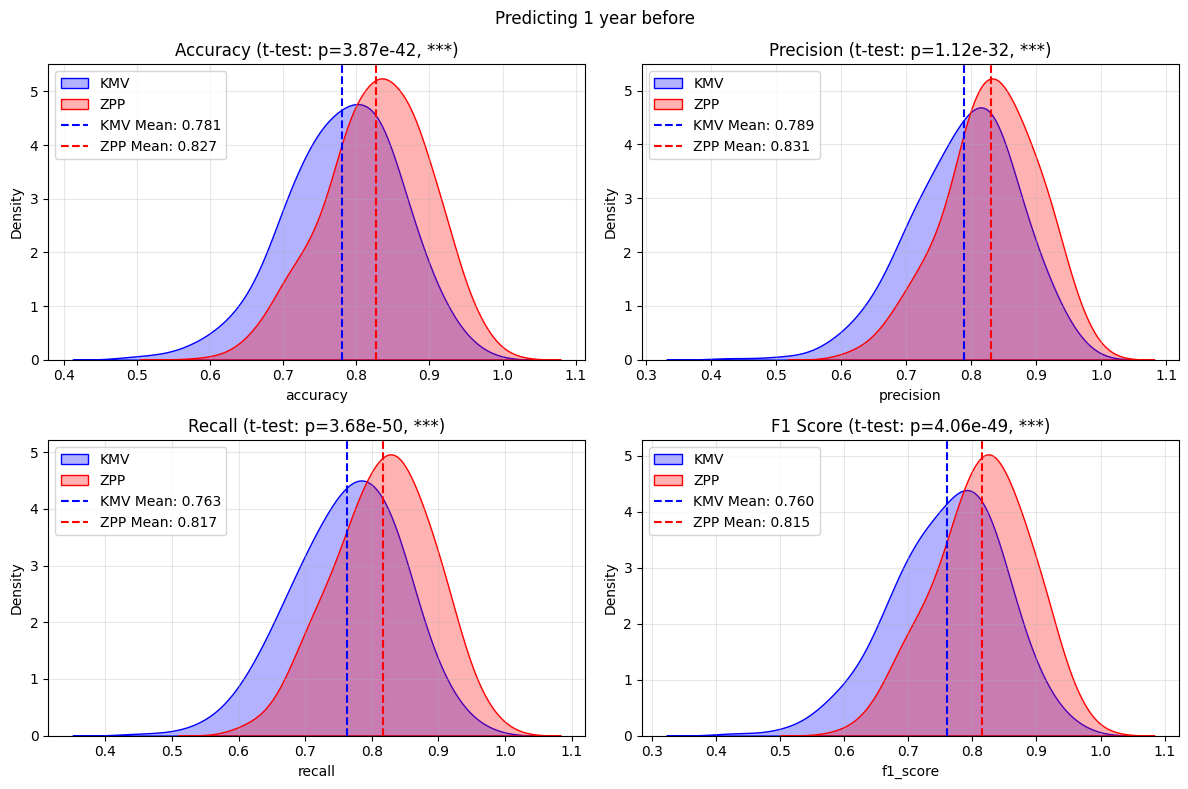

,KMV_CV,ZPP_CV,Difference,More_Stable
accuracy,0.099580,0.084993,0.014587,ZPP
precision,0.104898,0.087144,0.017754,ZPP
recall,0.108552,0.090555,0.017998,ZPP
f1_score,0.113754,0.091409,0.022344,ZPP


In [121]:
# === 1 year before ===

# Simulations
df_kmv = monte_carlo_lda_simulation(kmv_data.copy(), n_simulations=1000)
df_zpp = monte_carlo_lda_simulation(zpp_data.copy(), n_simulations=1000)

# Visualization with statistical comparison
compare_distributions_with_stats(df_kmv, df_zpp, trial_name= 'Predicting 1 year before')

# Stability (returns DataFrame)
stability_df = stability_analysis(df_kmv, df_zpp)
stability_df

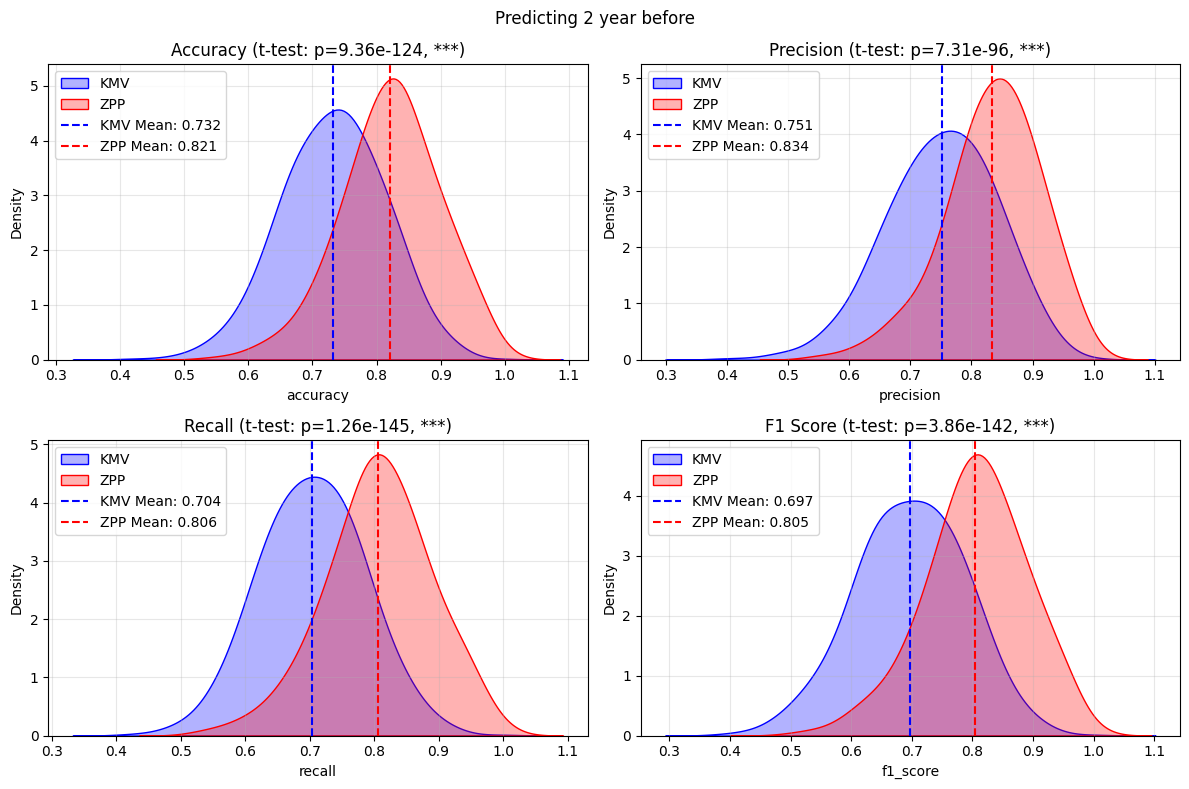

,KMV_CV,ZPP_CV,Difference,More_Stable
accuracy,0.109702,0.093124,0.016578,ZPP
precision,0.118740,0.093979,0.024761,ZPP
recall,0.115157,0.101930,0.013227,ZPP
f1_score,0.129208,0.104722,0.024487,ZPP


In [122]:
# === 2 year before ===

# Simulations
df_kmv = monte_carlo_lda_simulation(kmv_data.copy(), n_simulations=1000, exclude_last_n_cols = 4)
df_zpp = monte_carlo_lda_simulation(zpp_data.copy(), n_simulations=1000, exclude_last_n_cols = 4)

# Visualization with statistical comparison
compare_distributions_with_stats(df_kmv, df_zpp, trial_name= 'Predicting 2 year before')

# Stability (returns DataFrame)
stability_df = stability_analysis(df_kmv, df_zpp)
stability_df

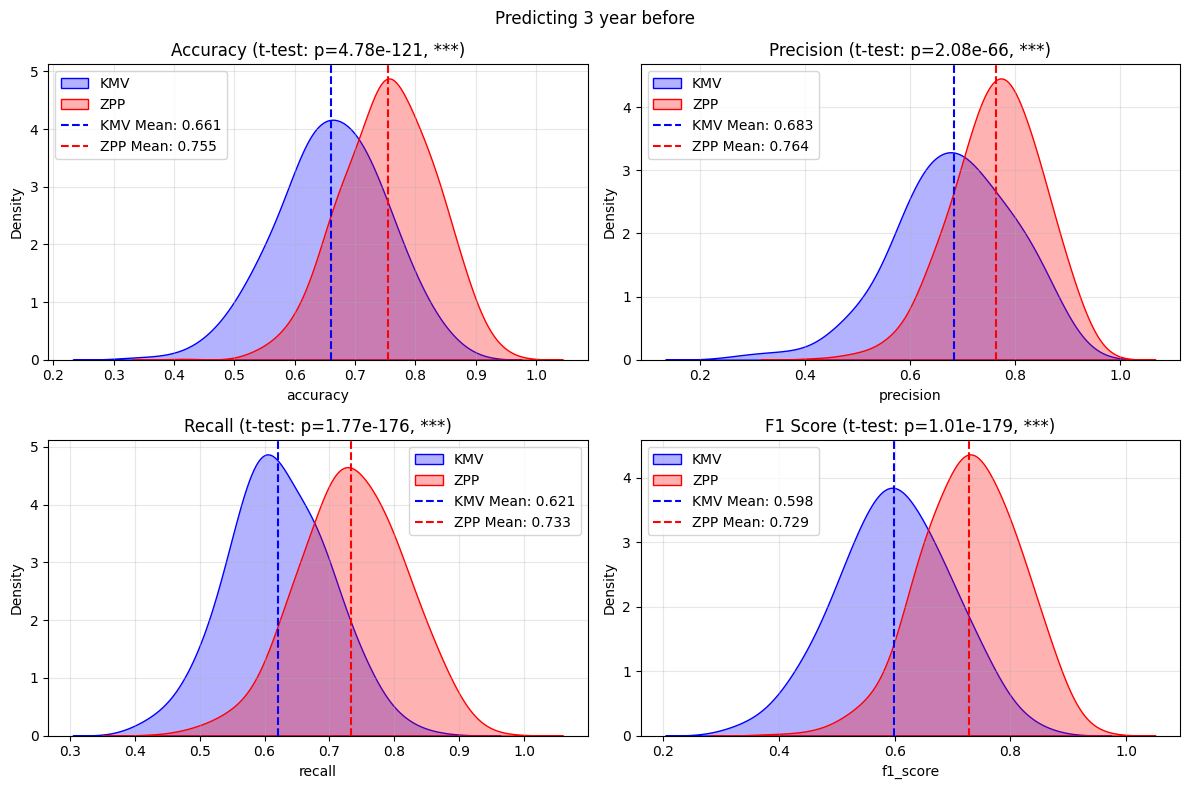

,KMV_CV,ZPP_CV,Difference,More_Stable
accuracy,0.135727,0.101416,0.034311,ZPP
precision,0.167223,0.111583,0.055640,ZPP
recall,0.126080,0.110042,0.016037,ZPP
f1_score,0.164096,0.116730,0.047366,ZPP


In [123]:
# === 3 year before ===

# Simulations
df_kmv = monte_carlo_lda_simulation(kmv_data.copy(), n_simulations=1000, exclude_last_n_cols = 8)
df_zpp = monte_carlo_lda_simulation(zpp_data.copy(), n_simulations=1000, exclude_last_n_cols = 8)

# Visualization with statistical comparison
compare_distributions_with_stats(df_kmv, df_zpp, trial_name= 'Predicting 3 year before')

# Stability (returns DataFrame)
stability_df = stability_analysis(df_kmv, df_zpp)
stability_df